## [데이터마이닝입문 과제4] 회귀 분석

### Logistic Regression
#### 데이터: Bank Data (기존의 KNN, LDA, QDA 포함 Regression Model 전반)

---

### 0) Logistic Regression이란?
(이번 과제의 목적이 비교분석이기 때문에 설명하는 부분도 있으면 좋을 것 같음)
<br>
내가 정리해뒀던 Regression model 부분인데, 혹시 부연설명 필요하면 여기 참고해두 좋을듯:<br>
https://zoeylaboratory.notion.site/Regression-Models-f672314973624d1fa1ffa6c970657a29

- 타겟 변수가 이진(0/1, 정기예금에 가입할 것이다, 아니다)로 나타나므로 로지스틱 회귀 모형 활용함.
- 우리가 사용하는 방식은 로지스틱 회귀 모형 중에서도 여러 개의 예측변수를 고려하는 다중 로지스틱 회귀 모형임.
- Model selection criteria forward, backward, stepwise 중에서 stepwise selection을 이용해서 타겟 변수 (정기예금 가입여부) 예측에 가장 무의미한 변수들을 제거하고 유의미한 변수들을 가지고 분석을 실행함. (Non Parititon: age, pdays, default, Partition: age, pdays, default, previous)
- 모형 적합 (Fitting logistic model)에서 glm 함수 내에 family 파라미터를 binomial(link = "logit")으로 설정해줌. 이 의미는 logistic regression을 이용해서 적합하라는 의미임.
- 모형 예측 (Predicting logistic model)에서는 cutoff 값을 0.5라는 임의의 값으로 설정함. 본래 cutoff는 prioir information (사전 정보): y가 0와 1 사이 비율에 대한 사전 정보, misclassification cost (오분류 비용): 1인데 0으로, 0인데 1로 오분류했을 때에 발생하는 비용, expert's opinion/domain knowledge으로 정해야 하지만 LDA/QDA에서 설정했던 0.5로 동일하게 설정해서 비교를 용이하게 함.

---

#### 아래 코드 순서:
1. Bank data Preparation (PPT에서는 생략가능, 이미 앞서 설명한거 사용)
2. Logistic Regression_No Parition ver.
3. Logistic Regression_Parititon ver.
4. CV
5. Comparison with KNN, LDA, QDA

### 1) Bank data Preparation

In [1]:
install.packages("class")
library(class)


The downloaded binary packages are in
	/var/folders/f9/t309_fcx7k5bdf4cxgrn_cdh0000gn/T//RtmpKGoxWn/downloaded_packages


In [2]:
bank = read.csv("bank_data.csv",header=T)
head(bank, 3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
bank$y = ifelse(bank$y == " yes", 1, 0) # yes = 1, no = 0
bank$y = factor(bank$y) # factor 자료형으로 변환

In [4]:
# target 변수 이외에도 deafult, loan, housing 변수 더미변환
bank$default = ifelse(bank$default == " yes", 1, 0) # yes = 1, no = 0
bank$loan = ifelse(bank$loan == " yes", 1, 0) # yes = 1, no = 0
bank$housing = ifelse(bank$housing == " yes", 1, 0) # yes = 1, no = 0

In [6]:
print(sum(is.na(bank))) # 총 11개의 결측치가 존재
bank = na.omit(bank)

[1] 11


In [7]:
print(sum(is.na(bank))) # 결측치가 제거된 모습

[1] 0


## NO PARTITION

### 2) Model Fitting

In [8]:
fit = glm(y ~., data = bank, family = binomial(link = "logit")) # yes/no로 분리되어 있기 때문에 binomial, logit 사용
summary(fit)
# 대부분의 변수가 target 변수를 예측함에 있어서 유의미한 것으로 보임


Call:
glm(formula = y ~ ., family = binomial(link = "logit"), data = bank)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.7271  -0.3745  -0.2531  -0.1502   3.4296  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.536e+00  1.837e-01 -13.804  < 2e-16 ***
age                  1.246e-04  2.205e-03   0.056 0.954954    
job blue-collar     -3.094e-01  7.267e-02  -4.258 2.07e-05 ***
job entrepreneur    -3.569e-01  1.256e-01  -2.842 0.004478 ** 
job housemaid       -5.039e-01  1.365e-01  -3.692 0.000222 ***
job management      -1.651e-01  7.329e-02  -2.253 0.024277 *  
job retired          2.522e-01  9.722e-02   2.595 0.009469 ** 
job self-employed   -2.981e-01  1.120e-01  -2.661 0.007782 ** 
job services        -2.256e-01  8.412e-02  -2.681 0.007331 ** 
job student          3.826e-01  1.090e-01   3.509 0.000450 ***
job technician      -1.757e-01  6.893e-02  -2.549 0.010791 *  
job unemployed      -1.764e-01  1.116e-

#### Stepwise Selection
: forward selection을 이용해서 유의미한 변수를 하나씩 넣다가, 모델에 어떤 영향을 주게 되면, 반응 변수와 크게 유의미하지 않은 부분은 제거하는 방법


In [9]:
# Model Selection criteria (direction=both로 지정함으로써 stepwise selection 사용함)
# 만약 forward 사용하려면 direction=forward, backward 사용하려면 direction=backward로 지정
fit2 = step(fit, direction = "both")
fit2$anova
summary(fit2)

# stepwise selection을 이용해서 모델의 변수 선택을 한 결과, 가장 먼저 age, default(credit 소유 유무), pdays(이전 캠페인에서 마지막으로 고객에서 연락한 후 경과일수)가 빠지는 것을 볼 수 있다.
# 3개의 변수는 타겟 변수 예측에 무의미함.

Start:  AIC=21646.56
y ~ age + job + marital + education + default + balance + housing + 
    loan + contact + day + month + duration + campaign + pdays + 
    previous + poutcome

            Df Deviance   AIC
- age        1    21561 21645
- default    1    21561 21645
- pdays      1    21561 21645
<none>            21561 21647
- previous   1    21563 21647
- balance    1    21566 21650
- day        1    21577 21661
- education  3    21588 21668
- marital    2    21599 21681
- loan       1    21614 21698
- job       11    21658 21722
- campaign   1    21655 21739
- housing    1    21802 21886
- contact    2    22101 22183
- month     11    22598 22662
- poutcome   3    22727 22807
- duration   1    27138 27222

Step:  AIC=21644.56
y ~ job + marital + education + default + balance + housing + 
    loan + contact + day + month + duration + campaign + pdays + 
    previous + poutcome

            Df Deviance   AIC
- default    1    21561 21643
- pdays      1    21561 21643
<none>        

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,45157,21560.56,21646.56
- age,1,0.003190579,45158,21560.56,21644.56
- default,1,0.010462954,45159,21560.57,21642.57
- pdays,1,0.111482712,45160,21560.68,21640.68



Call:
glm(formula = y ~ job + marital + education + balance + housing + 
    loan + contact + day + month + duration + campaign + previous + 
    poutcome, family = binomial(link = "logit"), data = bank)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.7272  -0.3747  -0.2532  -0.1502   3.4308  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.555e+00  1.311e-01 -19.489  < 2e-16 ***
job blue-collar     -3.098e-01  7.263e-02  -4.266 1.99e-05 ***
job entrepreneur    -3.571e-01  1.254e-01  -2.848 0.004400 ** 
job housemaid       -5.026e-01  1.360e-01  -3.695 0.000220 ***
job management      -1.650e-01  7.324e-02  -2.254 0.024227 *  
job retired          2.553e-01  8.739e-02   2.921 0.003489 ** 
job self-employed   -2.978e-01  1.120e-01  -2.660 0.007819 ** 
job services        -2.259e-01  8.411e-02  -2.686 0.007236 ** 
job student          3.822e-01  1.071e-01   3.570 0.000356 ***
job technician      -1.755e-01  6.89

### 3) Prediction

In [10]:
fit2.pred = predict(fit2, newdata = bank, type = "response") 

cutoff = 0.5
fit2.yhat = ifelse(fit2.pred <= cutoff, 0, 1)

ctable = table(bank$y, fit2.yhat,  dnn = c("Actual", "Predicted"))  
ctable

# prediction을 한 결과, 실제로 0인데 1이라고 예측한 경우(981건)보다 실제로 1인데 0이라고 잘못 예측한 경우(3459건)이 3배 가량 정도 많았음.
# 이 prediction 결과는 앞서 진행했던 KNN, LDA, QDA 분석과 동일한 결과를 보임.
# 데이터가 불균형 자료이기 때문에 (대부분이 0으로 이루어짐, KNN에서의 분포 참조) 0으로 예측하는 것으로 추정됨.

      Predicted
Actual     0     1
     0 38932   981
     1  3459  1828

### 4) Evaluation
Logistic Regression을 이용해서 예측한 결과, 오분류 비율: 0.0982, 정확도: 0.902, 민감도: 0.346, 특이도: 0.975를 보인다.<br>
기존 LDA, QDA와 동일한 cutoff=0.5로 반영한 결과임.
- KNN (NP)과의 비교: No Parition때 오분류 비율 0.085, 정확도 0.92, 민감도 0.46, 특이도 0.98로 오분류 비율과 민감도가 증가함.
- KNN (P)과의 비교: Parition때 오분류 비율 0.12, 정확도 0.89, 민감도 0.29, 특이도 0.96로 오분류 비율가 낮아짐.
- LDA (NP)와의 비교: No Parition때 오분류 비율 0.11, 정확도 0.88, 민감도 0.25, 특이도 0.97로 오분류 비율가 낮아짐.
- LDA (P)와의 비교: Parition때 오분류 비율 0.11, 정확도 0.88, 민감도 0.25, 특이도 0.97로 오분류 비율가 낮아짐.
- QDA (NP)와의 비교: No Parition때 오분류 비율 0.12, 정확도 0.87, 민감도 0.30, 특이도 0.95로 오분류 비율가 낮아짐.
- QDA (P)와의 비교: Parition때 오분류 비율 0.12, 정확도 0.87, 민감도 0.29, 특이도 0.95로 오분류 비율가 낮아짐.
<br>
<br>
여기서 비교하는건 우리가 PPT에 넣었던 표 다시 다 들고와서 비슷한 범위 내 값들을 보여준다고 보여주면 될듯.<br>
Logistic Regression과 비교했을 때에 KNN No parition일 때의 정확도가 더 높은 것으로 보임.

In [15]:
miss.err = 1-sum(diag(ctable))/sum(ctable) # Misclassification Rate
miss.err

pred.acc = 1 - miss.err # Prediction Accuracy
pred.acc  

diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity

[1] 0.09823009

[1] 0.9017699

1 
0.3457537

0 
0.9754215

### 6) AUC/ROC Curve

In [16]:
install.packages("ROCR")
library(ROCR)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’





The downloaded binary packages are in
	/var/folders/f9/t309_fcx7k5bdf4cxgrn_cdh0000gn/T//RtmpKGoxWn/downloaded_packages


[[1]]
[1] 0.9078778

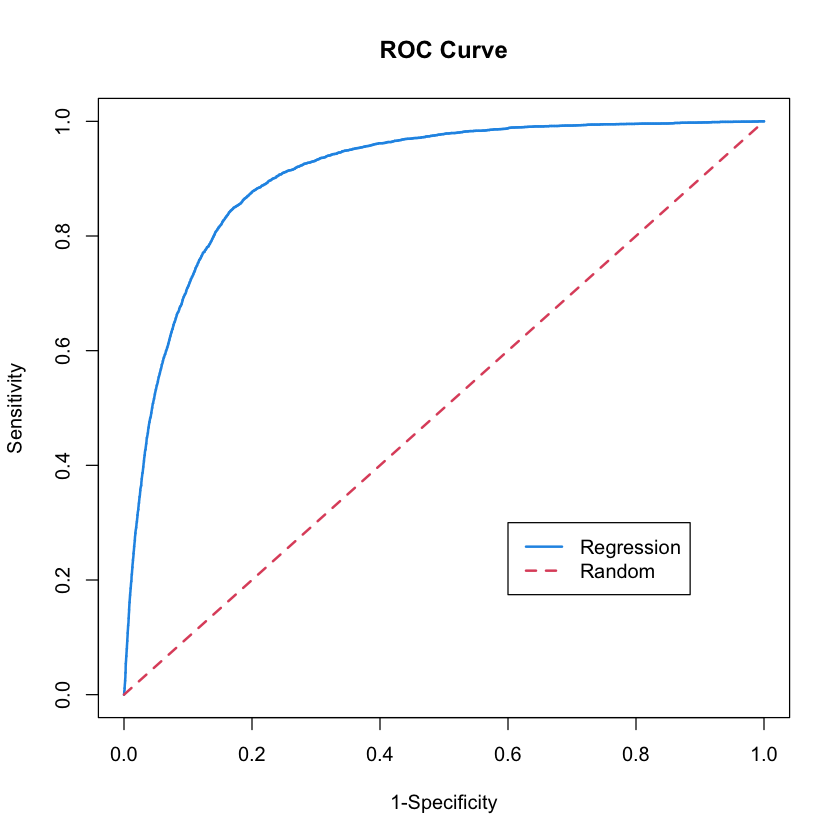

In [17]:
fit.pred = predict(fit, newdata =  bank, type = "response") 
pred = prediction(fit.pred, bank$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve") # ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.6, 0.3, legend = c("Regression","Random"), col = c(4,2), lty = c(1,2), lwd = 2)
performance(pred, "auc")@y.values # AUC

# ROC값: 0.907
# AUC curve 관찰시 random prediction보다 확연히 좋은 성능을 보임 (LDA, QDA에서의 값보다 더 높게 책정됨)

## PARTITION

### 7) Data Partitioning

In [18]:
set.seed(123)
V = 2
n =  NROW(bank)  # number of rows
id = sample(1:V, n, prob = c(0.7,0.3), replace = T) # Partitioning 7:3
ii = which(id==1)
bank.train = bank[ ii,]
bank.test  = bank[-ii,]

### 8) Model Fitting

In [20]:
fit = glm(y ~., data = bank.train, family = binomial(link = "logit"))
summary(fit)


Call:
glm(formula = y ~ ., family = binomial(link = "logit"), data = bank.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.6686  -0.3771  -0.2510  -0.1468   3.4022  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.382e+00  2.183e-01 -10.915  < 2e-16 ***
age                 -2.165e-03  2.642e-03  -0.819 0.412569    
job blue-collar     -4.104e-01  8.761e-02  -4.684 2.81e-06 ***
job entrepreneur    -3.785e-01  1.504e-01  -2.516 0.011877 *  
job housemaid       -6.982e-01  1.719e-01  -4.062 4.86e-05 ***
job management      -1.313e-01  8.642e-02  -1.520 0.128540    
job retired          2.862e-01  1.163e-01   2.461 0.013871 *  
job self-employed   -1.828e-01  1.305e-01  -1.401 0.161353    
job services        -2.203e-01  1.002e-01  -2.198 0.027927 *  
job student          4.264e-01  1.289e-01   3.309 0.000937 ***
job technician      -1.081e-01  8.131e-02  -1.329 0.183752    
job unemployed      -1.142e-01  1

In [22]:
# Stepwise model selection
fit2 = step(fit, direction = "both")
fit2$anova
summary(fit2)

# No parititon 때와 비교했을 때 (No partition에서는 age, default, pdays 순차적으로 제거됨) pdays - default - age - previous 순으로 무의미한 변수 제거됨.
# pdays, default, age는 동일하게 제거되지만 partition을 함으로써 previous 변수도 제거됨

Start:  AIC=15273.71
y ~ age + job + marital + education + default + balance + housing + 
    loan + contact + day + month + duration + campaign + pdays + 
    previous + poutcome

            Df Deviance   AIC
- pdays      1    15188 15272
- default    1    15188 15272
- age        1    15188 15272
- previous   1    15190 15274
<none>            15188 15274
- balance    1    15190 15274
- day        1    15197 15281
- education  3    15203 15283
- marital    2    15212 15294
- loan       1    15224 15308
- campaign   1    15261 15345
- job       11    15284 15348
- housing    1    15350 15434
- contact    2    15565 15647
- month     11    15937 16001
- poutcome   3    16060 16140
- duration   1    19065 19149

Step:  AIC=15271.71
y ~ age + job + marital + education + default + balance + housing + 
    loan + contact + day + month + duration + campaign + previous + 
    poutcome

            Df Deviance   AIC
- default    1    15188 15270
- age        1    15188 15270
- previous   1  

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,31806,15187.71,15273.71
- pdays,1,0.002300537,31807,15187.71,15271.71
- default,1,0.076127022,31808,15187.79,15269.79
- age,1,0.671499160,31809,15188.46,15268.46
- previous,1,1.892399070,31810,15190.35,15268.35



Call:
glm(formula = y ~ job + marital + education + balance + housing + 
    loan + contact + day + month + duration + campaign + poutcome, 
    family = binomial(link = "logit"), data = bank.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.6735  -0.3772  -0.2513  -0.1469   3.3992  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.456e+00  1.550e-01 -15.844  < 2e-16 ***
job blue-collar     -4.095e-01  8.752e-02  -4.679 2.88e-06 ***
job entrepreneur    -3.837e-01  1.502e-01  -2.554 0.010657 *  
job housemaid       -7.114e-01  1.714e-01  -4.151 3.30e-05 ***
job management      -1.336e-01  8.626e-02  -1.549 0.121473    
job retired          2.430e-01  1.043e-01   2.329 0.019846 *  
job self-employed   -1.844e-01  1.305e-01  -1.413 0.157622    
job services        -2.201e-01  1.002e-01  -2.197 0.028036 *  
job student          4.468e-01  1.265e-01   3.533 0.000410 ***
job technician      -1.082e-01  8.128e-02

### 9) Prediction

In [24]:
fit2.pred = predict(fit2, newdata =  bank.test, type = "response") 

cutoff = 0.5
fit2.yhat = ifelse(fit2.pred <= cutoff, 0, 1)

ctable = table(bank.test$y, fit2.yhat,  dnn = c("Actual", "Predicted")) 
ctable

# 실제로 0인데 1로 예측한 개수가 실제로 1인데 0으로 예측한 개수보다 3배 차이남 (No Partition때와 비슷한 양상)

      Predicted
Actual     0     1
     0 11531   274
     1  1037   509

### 10) Evaluation

In [25]:
miss.err = 1-sum(diag(ctable))/sum(ctable) # Misclassification Rate
miss.err

pred.acc = 1 - miss.err #Prediction Accuracy
pred.acc  

diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity 

# No partition 때와 비교했을 때(Logistic No Parition=오분류 비율: 0.0982, 정확도: 0.902, 민감도: 0.346, 특이도: 0.975),
# 오분류 비율, 정확도와 특이도는 거의 동일하지만 민감도는 살짝 감소한 것을 볼 수 있음
# 민감도: 실제로 정기예금에 가입한 사람 중 정기예금에 가입했다고 예측하는 비율인데 data를 partition하면서 더 적은 train 데이터로 예측하기 때문에 감소한 것으로 보임.

[1] 0.09819489

[1] 0.9018051

1 
0.3292367

0 
0.9767895

[[1]]
[1] 0.9073572

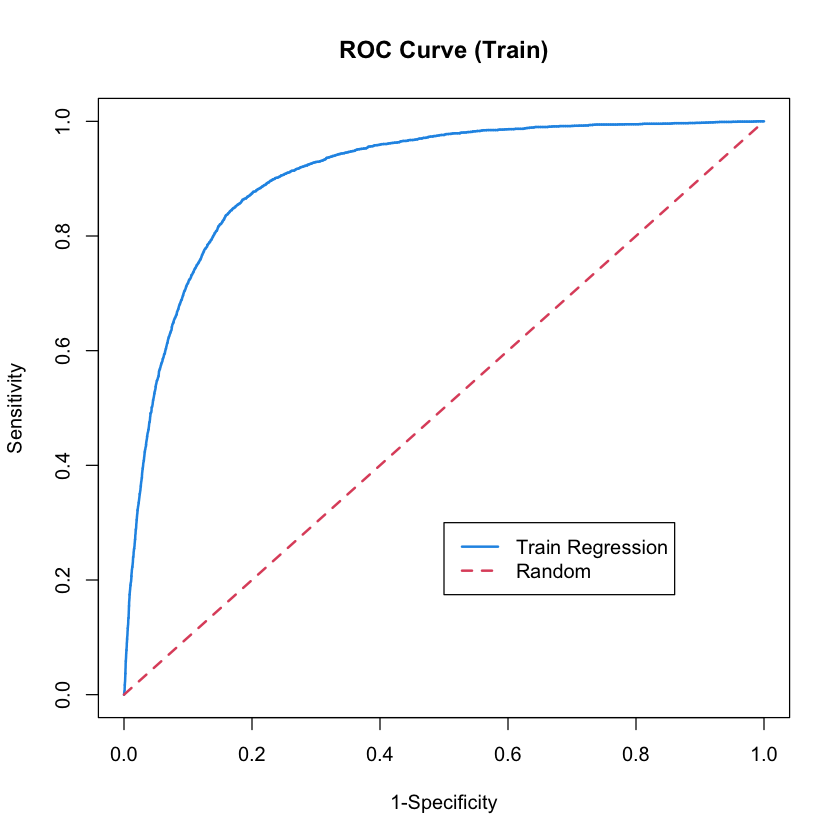

In [34]:
library(ROCR)

# Train data ROC, AUC
fit.pred = predict(fit, newdata = bank.train, type = "response") 
pred = prediction(fit.pred, bank.train$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Train)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.5, 0.3, legend = c("Train Regression","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

[[1]]
[1] 0.9048276

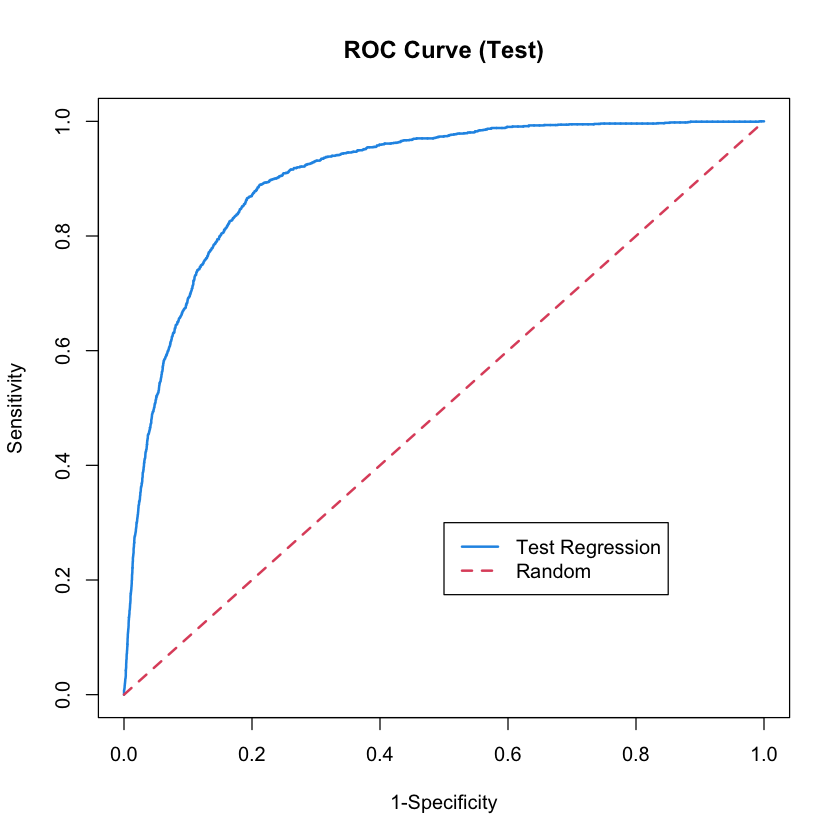

In [35]:
# Test data ROC, AUC
fit.pred = predict(fit, newdata = bank.test, type = "response") 
pred = prediction(fit.pred, bank.test$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Test)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.5, 0.3, legend = c("Test Regression","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

# No Partition 때의 ROC값이었던 0.907보다 살짝 감소하지만, 
# Train AUC와 Test AUC가 비슷하게 나타나는 것으로 보아 overfitting이 발생하지 않고 있다는 것을 알 수 있음.

## CV ERROR

### 11) 10-fold CV test Error

In [36]:
cutoff = 0.5

V = 10 # V-fold CV
miss.err.train = 0
miss.err.test = 0

set.seed(1234)
id = sample(1:V, nrow(bank), replace = T)

for(i in 1:V) {
  
  print(i)

  # Data Partitioning 
  bank.train = bank[id != i,] 
  bank.test  = bank[id == i,] 
  
  # Fitting
  fit = glm(y ~ ., data = bank.train, family = binomial(link = "logit"))
  fit2 = step(fit, direction="both", trace=FALSE) #Stepwise variable selection
  
  # Predicting and Evaluating
  pred.test = predict(fit2, newdata=bank.test, type="response")
  yhat.test = ifelse(pred.test<= cutoff, 0, 1)
  miss.err.test = miss.err.test + mean(bank.test$y != yhat.test)
  
}

cv.err.test = miss.err.test/V; cv.err.test # CV test error

# 10-fold cv test error을 얻은 결과, 오분류 비율이 0.099으로 앞서 No partition(0.098), Train/test partition(0.098) 때와 비슷한 값을 얻을 수 있다.

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


[1] 0.09866052

## COMPARISON
##### KNN, LDA, QDA와 비교했을 때 Logistic Regression의 위치는?
#### 정의적인 비교
- Regression: 로지스틱 회귀 모형에서는 예측한 값과 cutoff 값의 대소관계를 비교해서 0인지 1인지 예측함.
- KNN: 새로운 관측치의 특성을 가장 근접해 있는 k개의 관측치들의 평균값을 이용해 예측함. KNN은 근접한 이웃들의 값에 의존해서 새로운 관측치의 특성을 예측하게 됨.
- LDA: 직접적으로 P(Y=k|X=x) 를 구했던 로지스틱 회귀와는 다르게, LDA에서는 각각의 Y가 주어졌을때의 X의 분포, 즉 P(X|Y)를 통하여 ‘Bayes’ theorem’으로 P(Y=k|X=x)의 사후확률을 추정하고자 한다. 이 때 X의 분포, P(X|Y) 에 정규가정이 생긴다면, 로지스틱 회귀와 매우 유사한 형태가 된다.로지스틱 회귀 대신에 LDA를 사용하는 이유는 다음 3가지이다: 2개 이상의 범주가 있을 시 성능이 더 뛰어남, 범주가 명확하게 구분되어 있을 경우, 로지스틱 회귀는 굉장히 불안정한 결과를 낸다(계수가 쉽게 변동한다). 반면에 LDA는 그렇지 않음. 자료의 개수가 적을때에도 각 클래스에 대한 X의 분포가 정규분포와 유사하다면,  로지스틱 회귀보다 안정적인 성능을 보임.

- QDA: LDA에서 공분산이 같지 않다는 가정만 추가한 기법.

#### LDA VS. Logistic
로지스틱은 계수를 maximum likelihood로, LDA는 정규가정하에서 mean 과 variance의 추정으로 계수를 구하였기에, 이 둘의 계수 자체가 일치하지는 않지만, 선형 decision boundary를 만들어 낸다는 점에서 둘은 유사한 관계를 갖는다.
#### KNN VS. Logistic
KNN은 가장 가까운 k개의 관측치를 보고 그들의 특성에 따라 분류를 하는 것으로, 비모수적 방법이라고 볼 수 있다. 따라서 실제 decision boundary가 non-linear일 때 좋은 성능을 보일 수 있다. 그러나 어떤 변수가 중요했는지 등에 대한 해석력은 잃게 된다.
#### QDA VS. Logistic
QDA는 KNN과 LDA, 로지스틱회귀를 합친 특성을 가지고 있다. 이는 KNN보다는 flexible하지 않지만 decision boundary에 non-linear가정을 하였기에 LDA보다 flexible하고, 분포를 가정하였기에 KNN과 다르게 비교적 적은 데이터에서도 잘 적합할 수 있다.

결론적으로 Bank data에 대해서는 KNN, LDA, QDA, Logistic Regression No Partition/Partition 모두 비슷한 정확도/오분류 비율을 가짐. 좀 특징적인거라고 하면:
- Partition보다 No Partition에서 정확도가 조금씩 더 높음.
- Logistic Regression을 이용해서 ROC와 AUC를 시각화한 결과, 기존의 기법들에 비해 높은 값을 보임.
- Logistic Regression Partition에서 train AUC, test AUC 비슷함. overfitting 발생하지 않는 것으로 보임.